## 3. Horse Race Record Descriptive Analysis

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
import tsfresh

from sklearn.cluster import AgglomerativeClustering
from tslearn.clustering import GlobalAlignmentKernelKMeans
from tslearn.metrics import sigma_gak

def parse_rank_info(rank):
    # Parse rank information
    try:
        return re.search(r'\d+', rank).group(0)
    except AttributeError:
        return np.nan
    
def dtw_distance(ts_a, ts_b, d=lambda x, y: abs(x-y), window=0):
    # Calculate DTW distance
    if window <= 0:
        window = max(len(ts_a), len(ts_b))

    ts_a_len = len(ts_a)
    ts_b_len = len(ts_b)

    cost = np.empty((ts_a_len, ts_b_len))
    dist = np.empty((ts_a_len, ts_b_len))

    cost[0][0] = dist[0][0] = d(ts_a[0], ts_b[0])

    for i in range(1, ts_a_len):
        cost[i][0] = d(ts_a[i], ts_b[0])
        dist[i][0] = dist[i-1, 0] + cost[i, 0]

    for j in range(1, ts_b_len):
        cost[0][j] = d(ts_a[0], ts_b[j])
        dist[0][j] = dist[0, j-1] + cost[0, j]

    for i in range(1, ts_a_len):
        windowstart = max(1, i-window)
        windowend = min(ts_b_len, i+window)
        for j in range(windowstart, windowend):
            cost[i][j] = d(ts_a[i], ts_b[j])
            dist[i][j] = min(dist[i-1][j], dist[i][j-1], dist[i-1][j-1]) + cost[i][j]

    return dist[ts_a_len-1][ts_b_len-1]


# Set some specs for plotting
%matplotlib inline
%pylab inline
mpl.rcParams['figure.figsize'] = (16.0, 8.0)
mpl.style.use('ggplot')
plt.rcParams['font.family'] = 'IPAGothic'

# Read data from the data folder
race_df = pd.read_csv('data/race.csv', low_memory=False, index_col=0)
horse_df = pd.read_csv('data/horse.csv', low_memory=False, index_col=0)
horse_race_df = pd.read_csv('data/horse_race.csv', low_memory=False, index_col=0)

# Further preprocessing
horse_race_df['finishing_position'] = horse_race_df['finishing_position'].apply(lambda x: parse_rank_info(x))
horse_race_df = horse_race_df.dropna(subset=['finishing_position'])
horse_race_df['finishing_position'] = horse_race_df['finishing_position'].astype(int)
horse_race_df['age_int'] = horse_race_df['sex_age'].apply(lambda x: re.search(r'\d+', x).group(0)).astype(int)

C:\Users\terry\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Populating the interactive namespace from numpy and matplotlib


## 3.1 Horse Age and Speed

C:\Users\terry\AppData\Local\Continuum\Anaconda3\lib\site-packages\seaborn\categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


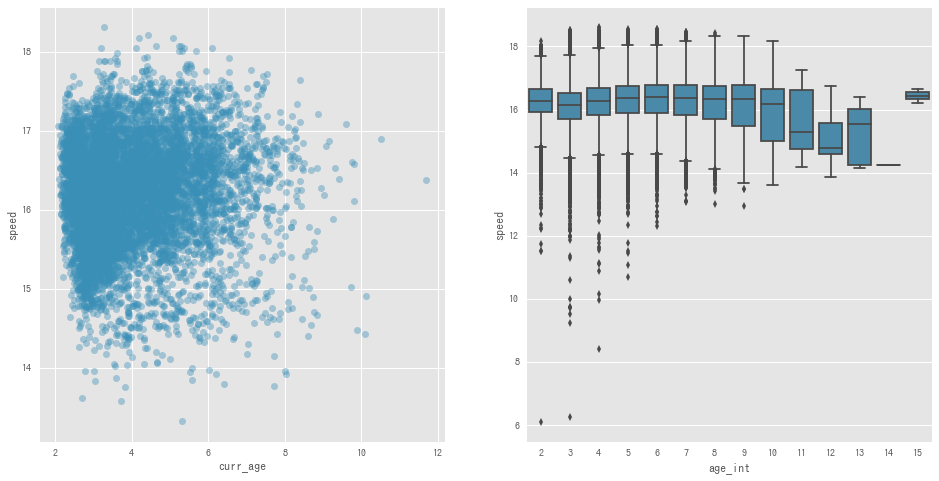

In [2]:
fig, ax = plt.subplots(1, 2)
time_age = horse_race_df.loc[:, ['horse_id', 'run_time', 'distance', 'curr_age', 'age_int']]
time_age['speed'] = time_age['distance'] / time_age['run_time']
sns.regplot(x='curr_age', y='speed', data=time_age.sample(n=10000), fit_reg=False, 
            color='#3A8FB7', ax=ax[0], scatter_kws={'alpha': .4})
sns.boxplot(x='age_int', y='speed', data=time_age, color='#3A8FB7', ax=ax[1])

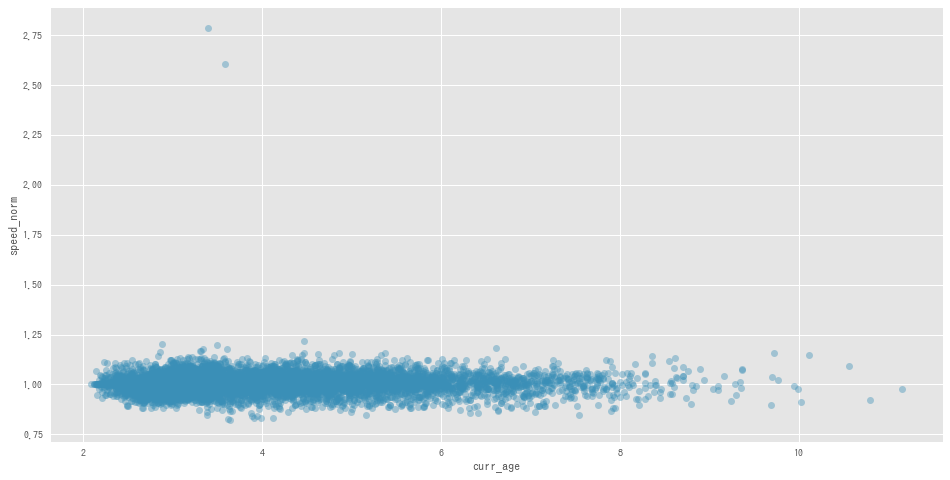

In [3]:
time_age = time_age.sort_values(['horse_id', 'curr_age'])
time_age['speed'] = time_age['speed'].astype(str)
time_age['curr_age'] = time_age['curr_age'].astype(str)
speed_perf = time_age.groupby('horse_id').agg({'curr_age': lambda x: ', '.join(x), 'speed': lambda x: ', '.join(x)})
speed_perf = speed_perf.applymap(lambda x: list(map(lambda y: float(y), x.split(', '))))
speed_perf['speed'] = speed_perf['speed'].apply(lambda x: list(map(lambda y: (y - x[0]) / x[0] + 1, x)))
speed = speed_perf['speed'].apply(pd.Series).stack().reset_index().set_index('horse_id')[0]
time_age['speed_norm'] = pd.Series(list(speed), index=time_age.index)
time_age['curr_age'] = time_age['curr_age'].astype(float)
time_age['speed_norm']  = time_age['speed_norm'].astype(float)
sns.regplot(x='curr_age', y='speed_norm', data=time_age.sample(n=10000), fit_reg=False, color='#3A8FB7', scatter_kws={'alpha': .4})

## 3.2 Time Series Analysis and Clustering

### 3.2.1 Exploratory Analysis

C:\Users\terry\AppData\Local\Continuum\Anaconda3\lib\site-packages\seaborn\categorical.py:637: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data[hue_mask])
C:\Users\terry\AppData\Local\Continuum\Anaconda3\lib\site-packages\seaborn\categorical.py:932: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data[hue_mask])


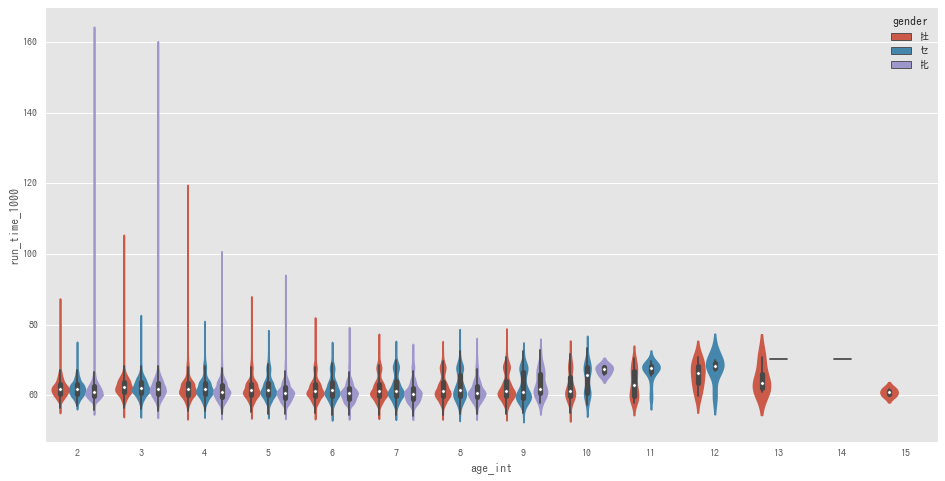

In [4]:
sns.violinplot(x='age_int', y='run_time_1000', hue='gender', data=horse_race_df)

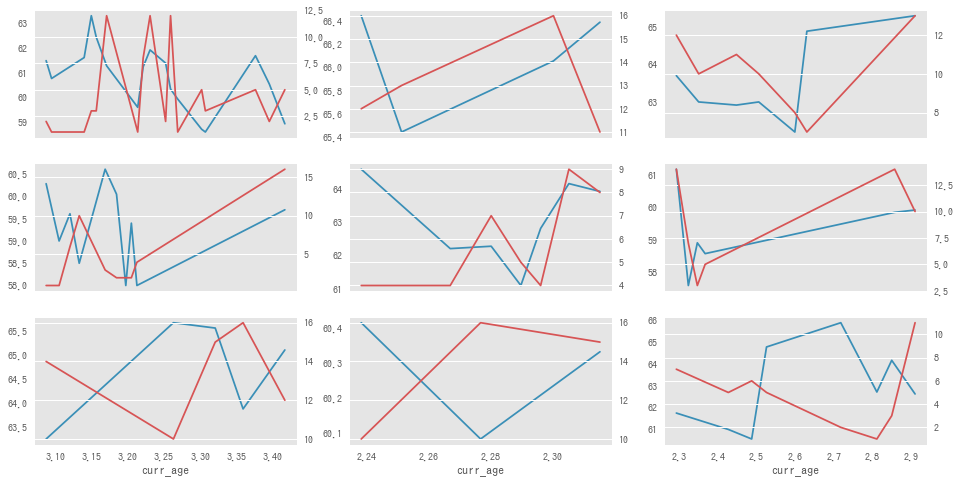

In [5]:
# Randomly choose horses to plot
id_count = horse_race_df['horse_id'].value_counts()
id_count = id_count[id_count > 1]
plot_num = 3
fig, ax = plt.subplots(plot_num, plot_num)
for i_idx in range(plot_num):
    for j_idx in range(plot_num):
        random_index = id_count.sample(n=1).index
        random_horse_record = horse_race_df.loc[horse_race_df['horse_id'].isin(random_index)]
        '''
            Blue: Run time
            Red: Finishing position (rank)
        '''
        random_horse_record.sort_values('curr_age').plot(x='curr_age', y='run_time_1000', 
                                                         color='#3A8FB7', ax=ax[i_idx][j_idx], 
                                                         legend=None)
        random_horse_record.sort_values('curr_age').plot(x='curr_age', y='finishing_position', 
                                                         color='#D75455', ax=ax[i_idx][j_idx], 
                                                         legend=None, secondary_y=True)

### 3.2.2 Global Alignment Kernel (GAK)

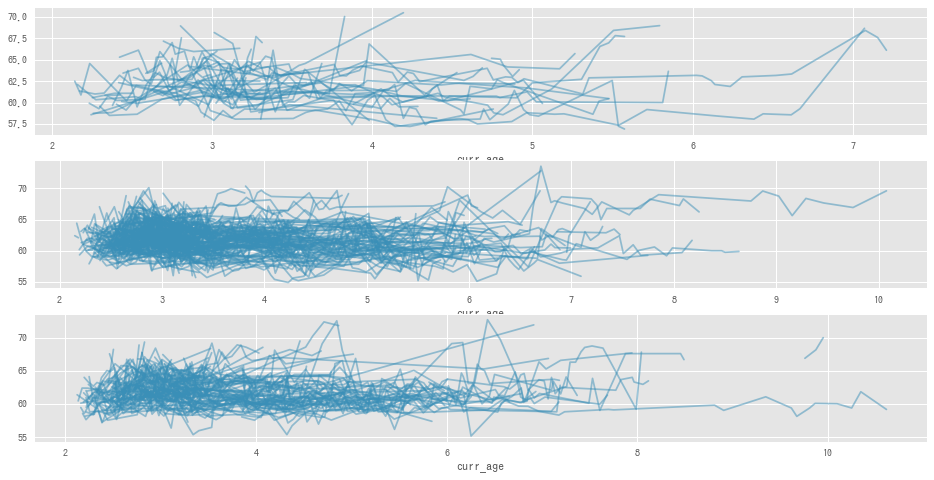

In [6]:
sample_horse = horse_race_df['horse_id'].value_counts().sample(n=500).index
sample_data = horse_race_df.loc[horse_race_df['horse_id'].isin(sample_horse), ['horse_id', 'run_time_1000', 'curr_age']]
sample_data = sample_data.sort_values(['horse_id', 'curr_age'])
sample_data['run_time_1000'] = sample_data['run_time_1000'].astype(str)
final = sample_data.groupby('horse_id')['run_time_1000']
final = final.apply(lambda x: list(map(lambda x: float(x), ', '.join(x).split(', '))))
train = np.array(final)
numpy.random.shuffle(train)

num_cluster = 3
gak_km = GlobalAlignmentKernelKMeans(n_clusters=num_cluster, n_init=20, verbose=False, sigma=sigma_gak(train))
pred = gak_km.fit_predict(train)
sample_data = sample_data.merge(pd.DataFrame(pd.Series(pred, index=final.index, name='Cluster')).reset_index(), on='horse_id')

sample_data['curr_age'] = sample_data['curr_age'].astype(float)
sample_data['run_time_1000'] = sample_data['run_time_1000'].astype(float)

fig, ax = plt.subplots(num_cluster, 1)

for cluster in range(num_cluster):
    data = sample_data.loc[sample_data['Cluster'] == cluster]
    for horse_id in data.horse_id.value_counts().index:
        data.loc[data['horse_id'] == horse_id].plot(x='curr_age', y='run_time_1000', 
                                                    ax=ax[cluster], legend=None, color='#3A8FB7', alpha=.5)

### 3.2.3 Dynamic Time Warping (DTW)

DTW distance: 0.72


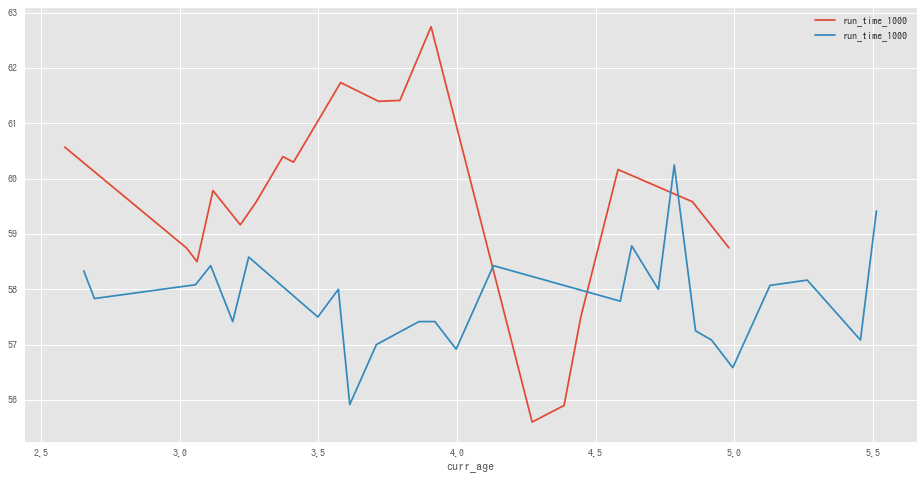

In [7]:
# Reference:
# https://datascience.stackexchange.com/questions/19040/clustering-multivariate-time-series-datasets
# https://stackoverflow.com/questions/40955728/clustering-algorithms-with-custom-distance-function-in-python
# https://stats.stackexchange.com/questions/131281/dynamic-time-warping-clustering/131337#131337

sorted_final = final[final.apply(lambda x: len(x)).sort_values(ascending=False).index].iloc[:100]
sample_data['run_time_1000'] = sample_data['run_time_1000'].astype(float)
sample_x = sorted_final.sample(n=1)
sample_y = sorted_final.sample(n=1)
x = array(sample_x.iloc[0]).reshape([-1, 1])
y = array(sample_y.iloc[0]).reshape([-1, 1])
dist, cost, acc, path = dtw_distance(x, y)

print('DTW distance: %.2f' % dist)
fig, ax = plt.subplots()
sample_data[sample_data['horse_id'].isin(sample_x.index)].plot(x='curr_age', y='run_time_1000', ax=ax)
sample_data[sample_data['horse_id'].isin(sample_y.index)].plot(x='curr_age', y='run_time_1000', ax=ax)

In [8]:
dist_matrix = np.zeros((sorted_final.shape[0], sorted_final.shape[0]))
dist_dict = {}
distance_list = list(sorted_final)
for i in range(len(distance_list)):
    for j in range(i, len(distance_list)):
        if i == j:
            dist_matrix[i][j] = 0
        else:
            x = array(distance_list[i]).reshape([-1, 1])
            y = array(distance_list[j]).reshape([-1, 1])
            dist_matrix[i][j] = dtw_distance(x, y)
            dist_matrix[j][i] = dist_matrix[i][j]

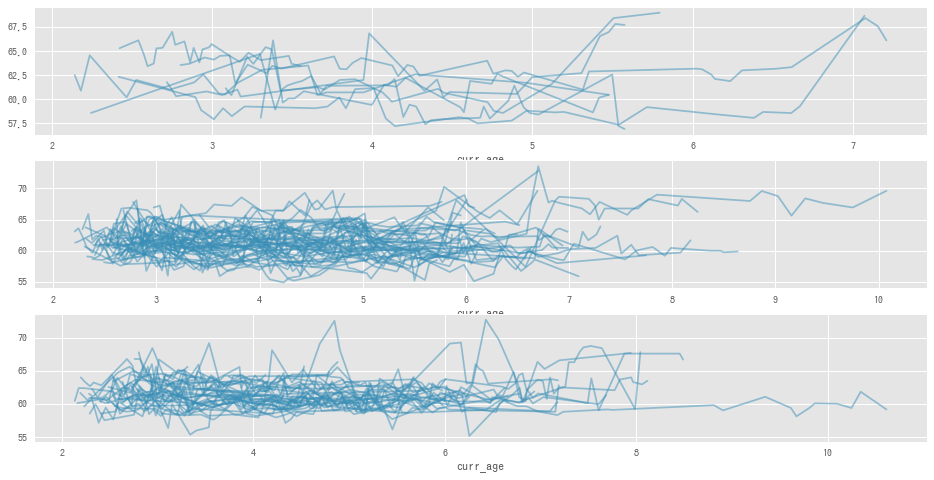

In [9]:
ag = AgglomerativeClustering(n_clusters=3, affinity='precomputed', linkage='complete')
ag.fit(dist_matrix)
clusters = pd.Series(ag.labels_, index=sorted_final.index, name='Cluster_DTW')
sample_data = sample_data.merge(pd.DataFrame(clusters).reset_index(), on='horse_id')

fig, ax = plt.subplots(ag.n_clusters, 1)

for cluster in range(ag.n_clusters):
    data = sample_data.loc[sample_data['Cluster'] == cluster]
    for horse_id in data.horse_id.value_counts().index:
        data.loc[data['horse_id'] == horse_id].plot(x='curr_age', y='run_time_1000', 
                                                    ax=ax[cluster], legend=None, color='#3A8FB7', alpha=.5)